In [1]:
from data import train_df, test_df
import numpy as np
import pandas as pd

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

*Remover entradas que possuem NaN reduz bastante o tamanho do dataset*

In [ ]:
train_df.dropna().describe()

## Análise inicial

In [ ]:
# pra ver quantas pessoas sobreviveram
train_df["Survived"].value_counts()

In [ ]:
# pra ver os percentuais de quem sobreviveu
train_df["Survived"].value_counts(normalize = True)

In [ ]:
# quantos homens sobreviveram
train_df["Survived"][train_df["Sex"] == 'male'].value_counts(normalize=True)

In [ ]:
# quantas mulheres sobreviveram
train_df["Survived"][train_df["Sex"] == 'female'].value_counts(normalize=True)

Proporcionalmente, um número maior de mulheres sobreviveram. Seria por causa da política de "mulheres e crianças primeiro"?

In [ ]:
# Existe o campo "Child"?
train_df.info()

In [ ]:
# Completando os valores em branco para a mediana da feature "Age".
# Usamos mediana ao invés de média por ela ser menos sensível a outliers (i.e., a mediana é uma estatística robusta).
train_df['Age'] = train_df["Age"].fillna(train_df["Age"].median())
train_df["Child"] = 0
children = train_df["Age"] < 18
train_df.loc[children, "Child"] = 1
train_df["Survived"][train_df["Child"] == 0].value_counts(normalize=True)

In [ ]:
# A feature 'Sex' precisa ser mapeada para inteiros
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})

In [9]:
from sklearn import tree

In [ ]:
# Vamos usar então as features 'Sex' e 'Child' para uma classificacao inicial

# Separando o resultado e as features usadas
target = train_df['Survived'].values
initial_features = train_df[['Sex', 'Child']].values

# Da classifier
my_tree_one = tree.DecisionTreeClassifier().fit(initial_features, target)

# Vamos checar a importância relativa de cada feature e o score obtido no conjunto de treinamento
print(my_tree_one.feature_importances_)
print(my_tree_one.score(initial_features, target))

In [8]:
import pydotplus as pydot
from sklearn.externals.six import StringIO
from IPython.display import Image 

def plot_tree(da_tree):
    dotfile = StringIO()
    tree.export_graphviz(da_tree, out_file=dotfile)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    return Image(graph.create_png())

In [ ]:
plot_tree(my_tree_one)

A árvore de decisão funciona aplicando as decisões de cada nível ao exemplo passado como entrada. Ao se chegar a uma folha, a árvore checa o que aconteceu com a maioria dos exemplos que possuem aquelas características: se a maioria tiver sobrevivido, a árvore decide que o novo exemplo também deve ter sobrevivido. TODO: observações sobre o efeito de permutação de features na árvore resultante.

In [ ]:
# Por exemplo, existem 55 crianças do sexo feminino no conjunto de treinamento. A maioria delas sobreviveram,
# o que pode ser visto na filtragem abaixo...
temp = train_df[train_df['Child'] == 1]
female_children = temp[temp['Sex'] == 1]
female_children.groupby('Survived').describe()

In [ ]:
# Vamos definir algumas constantes para ajudar com a legibilidade dos dados.
DIED = 0
SURVIVED = 1

MALE = 0
FEMALE = 1    

In [ ]:
# ...Logo, ao se passar para a árvore um exemplo consistindo de uma
# criança do sexo feminino, a árvore decidirá que ela deve ter sobrevivido.
new_female_child = pd.DataFrame(data=[[FEMALE, 1]], columns=['Gender', 'Child'])
prediction = my_tree_one.predict(new_female_child)

if (prediction[0] == SURVIVED):
    print('Survived :D')
else:
    print('Died :(')

In [20]:
def encode_gender_and_child(input_dataframe):
    encoded_dataframe = input_dataframe.copy()
    
    encoded_dataframe['Sex'] = encoded_dataframe['Sex'].map({'male': MALE, 'female': FEMALE})
    
    encoded_dataframe['Age'] = encoded_dataframe["Age"].fillna(encoded_dataframe["Age"].median())
    encoded_dataframe["Child"] = 0
    children = encoded_dataframe["Age"] < 18
    encoded_dataframe.loc[children, "Child"] = 1
    
    return encoded_dataframe.drop('Age', 1)

def extract_features_from_dataframe(dataframe, feature_names):
    return dataframe.ix[:, feature_names]

In [ ]:
test_features_df = extract_features_from_dataframe(test_df, ['Sex', 'Age'])
encoded_test_df = encode_gender_and_child(test_features_df)

test_targets = my_tree_one.predict(encoded_test_df.values)

In [ ]:
test_results_csv = extract_features_from_dataframe(test_df, ['PassengerId'])
test_results_csv['Survived'] = test_targets
test_results_csv.to_csv('./data/first_attempt.csv', index=False)

#### Com esse conjunto de dados a gente já consegue prever sobrevivência com uma precisão de 0.76555 no conjunto de dados usado para avaliar as submissões do Kaggle.

## Inclusão das features "Cabin" e "Fare"

In [ ]:
cabin_fare_df = train_df.ix[:, ['Cabin', 'Fare']]
cabin_fare_df.info()

In [ ]:
len(cabin_fare_df['Cabin'].unique())

A feature "Cabin" é categórica com um range relativamente grande(148 valores diferentes) e várias entradas vazias. Não é adequado codificar essa feature como uma sequência numérica pois isso implicaria uma ordenação dos valores, o que não condiz com a semântica dessa feature e poderia levar a resultados incoerentes. Essa feature será ignorada nesse momento e analisada por último como uma possível inclusão de informação para melhora do resultado final.

In [ ]:
def get_tree_for_features(features):
    target = train_df['Survived'].values
    feature_values = train_df[features].values
    
    # Da classifier
    return (tree.DecisionTreeClassifier().fit(feature_values, target), feature_values, target)

In [ ]:
features = ['Sex', 'Child', 'Fare']
third_tree, feature_values, target = get_tree_for_features(features)

# Score obtido no dataset de treinamento
third_tree.score(feature_values, target)

Temos uma árvore treinada agora com as features *Sex*, *Child* e *Fare*. Vamos gerar as previsões para o dataset de testes.

In [ ]:
test_features_df = extract_features_from_dataframe(test_df, ['Sex', 'Age', 'Fare'])
# O final da linha abaixo garante que as colunas estarão na ordem correta
encoded_test_df = encode_gender_and_child(test_features_df)[features]

encoded_test_df['Fare'] = encoded_test_df['Fare'].fillna(encoded_test_df['Fare'].median())
encoded_test_df.describe()

In [ ]:
test_features = encoded_test_df.values
predictions = third_tree.predict(test_features)

In [ ]:
test_results_csv = extract_features_from_dataframe(test_df, ['PassengerId'])
test_results_csv['Survived'] = predictions
test_results_csv.to_csv('./data/second_attempt.csv', index=False)

A inclusão da feature 'Fare' fez com que a classificação da submissão melhorasse em cerca de 1% (para 0.77990) - no ranking geral, no entanto, isso foi suficiente para subir 1104 posições lol

# Inclusão das features 'SipSp' e 'Parch'

Vamos explorar agora o efeito de se adicionar a feature "SibSp", que indica quantos irmãos ou cônjuges a pesssoa tinha dentro do navio.

In [ ]:
original_features = ['Sex', 'Age', 'Fare', 'SibSp']
model_features = ['Sex', 'Child', 'Fare', 'SibSp']
fourth_tree, feature_values, target = get_tree_for_features(model_features)

fourth_tree.score(feature_values, target)

In [ ]:
test_features_df = extract_features_from_dataframe(test_df, original_features)
encoded_test_df = encode_gender_and_child(test_features_df)[model_features]

encoded_test_df['Fare'] = encoded_test_df['Fare'].fillna(encoded_test_df['Fare'].median())

test_results_csv = extract_features_from_dataframe(test_df, ['PassengerId'])
test_results_csv['Survived'] = fourth_tree.predict(encoded_test_df.values)
test_results_csv.to_csv('./data/third_attempt.csv', index=False)

A inclusão da feature 'SibSp' piorou o score obtido no conjunto de testes do Kaggle(o score baixou para 0.76555). Uma possível explicação seria a concentração de exemplos com valores 0 e 1 nessa feature para o conjunto de treinamento, o que torna a feature pouco descritiva.

Vamos tentar usar a feature 'Parch' no lugar de 'SibSp'. Essa feature descreve quantos pais ou filhos uma pessoa tem a  bordo do navio.

In [ ]:
train_df.groupby('Parch').describe()

In [ ]:
original_features = ['Sex', 'Age', 'Fare', 'Parch']
model_features = ['Sex', 'Child', 'Fare', 'Parch']
fifth_tree, feature_values, target = get_tree_for_features(model_features)

fifth_tree.score(feature_values, target)

In [ ]:
test_features_df = extract_features_from_dataframe(test_df, original_features)
encoded_test_df = encode_gender_and_child(test_features_df)[model_features]

encoded_test_df['Fare'] = encoded_test_df['Fare'].fillna(encoded_test_df['Fare'].median())

test_results_csv = extract_features_from_dataframe(test_df, ['PassengerId'])
test_results_csv['Survived'] = fifth_tree.predict(encoded_test_df.values)
test_results_csv.to_csv('./data/fourth_attempt.csv', index=False)

Do mesmo, a inclusão da feature 'Parch' piorou o score no Kaggle(para 0.75120). Essa feature segue uma distribuição parecida com a da feature 'SibSp', o que pode explicar o motivo do resultado também ter sido semelhante.

# Inclusão da feature 'Pclass'

Temos a hipótese de que a inclusão de Pclass não terá muito impacto no score obtido já que ela serve como um proxy para a classe socio-econômica dos passageiros, o que pode já estar representado pela feature 'Fare'.

In [ ]:
train_df.Pclass.unique()

In [ ]:
# Podemos usar a feature Pclass diretamente, já que ela é numérica e não possui entradas em branco
features = ['Sex', 'Child', 'Fare', 'Pclass']
sixth_tree, feature_values, target = get_tree_for_features(features)

sixth_tree.score(feature_values, target)

O impacto no score no conjunto de treinamento foi bastante pequeno em relação ao score obtido apenas com as features 'Sex', 'Child' e 'Fare'(0.9135802469135802). Vamos checar se o score permanece semelhante ao se substituir o uso da feature 'Fare' por 'Pclass'.

In [ ]:
features = ['Sex', 'Child', 'Pclass']
seventh_tree, feature_values, target = get_tree_for_features(features)

seventh_tree.score(feature_values, target)

Interessante :) </br> Será que as cabines mais caras ficavam mais próximas aos botes salva-vidas? Será que nem todas as cabines da primeira classe eram seguras?

In [ ]:
first_class = train_df[train_df['Pclass'] == 1]
second_class = train_df[train_df['Pclass'] == 2]
third_class = train_df[train_df['Pclass'] == 3]

In [ ]:
first_class['Survived'].value_counts(normalize=True)

In [ ]:
second_class['Survived'].value_counts(normalize=True)

In [ ]:
third_class['Survived'].value_counts(normalize=True)

### Analisando Embarked

In [ ]:
train_df['Embarked'].unique()

In [ ]:
train_df['Embarked'].value_counts()

In [ ]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')

In [ ]:
# ao invés de sobrescrever a feature "Embarked", a gente cria uma nova feature que será usada somente
# no experimento que estamos fazendo agora

train_df['encoded_Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [ ]:
features = ['Sex', 'Child', 'Fare', 'encoded_Embarked']
eighth_tree, feature_values, target = get_tree_for_features(features)

eighth_tree.score(feature_values, target)

A inclusão da feature 'Embarked' codificada como números sequenciais não melhorou muito a taxa de acerto anterior(0.9135802469135802). Vamos checar se o uso de One-Hot Encoding faz diferença.

In [ ]:
embarked_S_indices = train_df['Embarked'] == 'S'
embarked_C_indices = train_df['Embarked'] == 'C'
embarked_Q_indices = train_df['Embarked'] == 'Q'
train_df['Embarked_S'] = 0
train_df['Embarked_C'] = 0
train_df['Embarked_Q'] = 0
train_df.loc[embarked_S_indices, 'Embarked_S'] = 1
train_df.loc[embarked_C_indices, 'Embarked_C'] = 1
train_df.loc[embarked_Q_indices, 'Embarked_Q'] = 1

In [ ]:
features = ['Sex', 'Child', 'Fare', 'Embarked_S', 'Embarked_C', 'Embarked_Q']
ninth_tree, feature_values, target = get_tree_for_features(features)

ninth_tree.score(feature_values, target)

O score permaneceu inalterado, o que invalida nossa hipótese anterior. Vamos checar como a árvore está processando a feature 'Embarked' com a codificação numérica.

In [ ]:
plot_tree(eighth_tree)

Pode-se notar que a árvore usa a feature 'Embarked' em várias etapas durante o caminho que ela percorre para tomar uma decisão. Isso pode explicar o motivo de a codificação ingênua ter funcionado bem, pois apesar de se ter introduzido uma semântica de ordem, o fato de a árvore realizar vários "cortes" nos valores dessa feature faz com que, na prática, ela identifique as diferentes categorias abrangidas pela feature.

## Seleção automática de features

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
def impute_null_attributes(dataset):
    imputed_dataset = dataset.copy()
    for attribute in dataset:
        if dataset[attribute].dtype == 'O':
            imputed_dataset[attribute] = imputed_dataset[attribute].fillna(dataset[attribute].dropna().mode()[0])
        elif dataset[attribute].dtype in ('int64', 'float64'):
            imputed_dataset[attribute] = imputed_dataset[attribute].fillna(dataset[attribute].dropna().median())

    return imputed_dataset

In [4]:
imputed_dataset = impute_null_attributes(train_df.drop(['Name', 'Survived'], 1))

In [5]:
def encode_object_attributes(dataset):
    encoded_dataset = dataset.copy()
    for attribute in dataset:
        if dataset[attribute].dtype == 'O':
            encoded_dataset[attribute], _ = pd.factorize(encoded_dataset[attribute])

    return encoded_dataset

In [6]:
encoded_dataset = encode_object_attributes(imputed_dataset)

In [7]:
encoded_dataset.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,0.352413,29.361582,0.523008,0.381594,306.859708,32.204208,15.101010,0.361392
std,257.353842,0.836071,0.477990,13.019697,1.102743,0.806057,197.286045,49.693429,34.529013,0.635673
min,1.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,0.000000,22.000000,0.000000,0.000000,135.000000,7.910400,0.000000,0.000000
50%,446.000000,3.000000,0.000000,28.000000,0.000000,0.000000,285.000000,14.454200,0.000000,0.000000
75%,668.500000,3.000000,1.000000,35.000000,1.000000,0.000000,474.500000,31.000000,0.000000,1.000000
max,891.000000,3.000000,1.000000,80.000000,8.000000,6.000000,680.000000,512.329200,146.000000,2.000000


In [16]:
target = train_df['Survived'].values
feature_values = encoded_dataset.values
    
all_features_tree = tree.DecisionTreeClassifier().fit(feature_values, target)

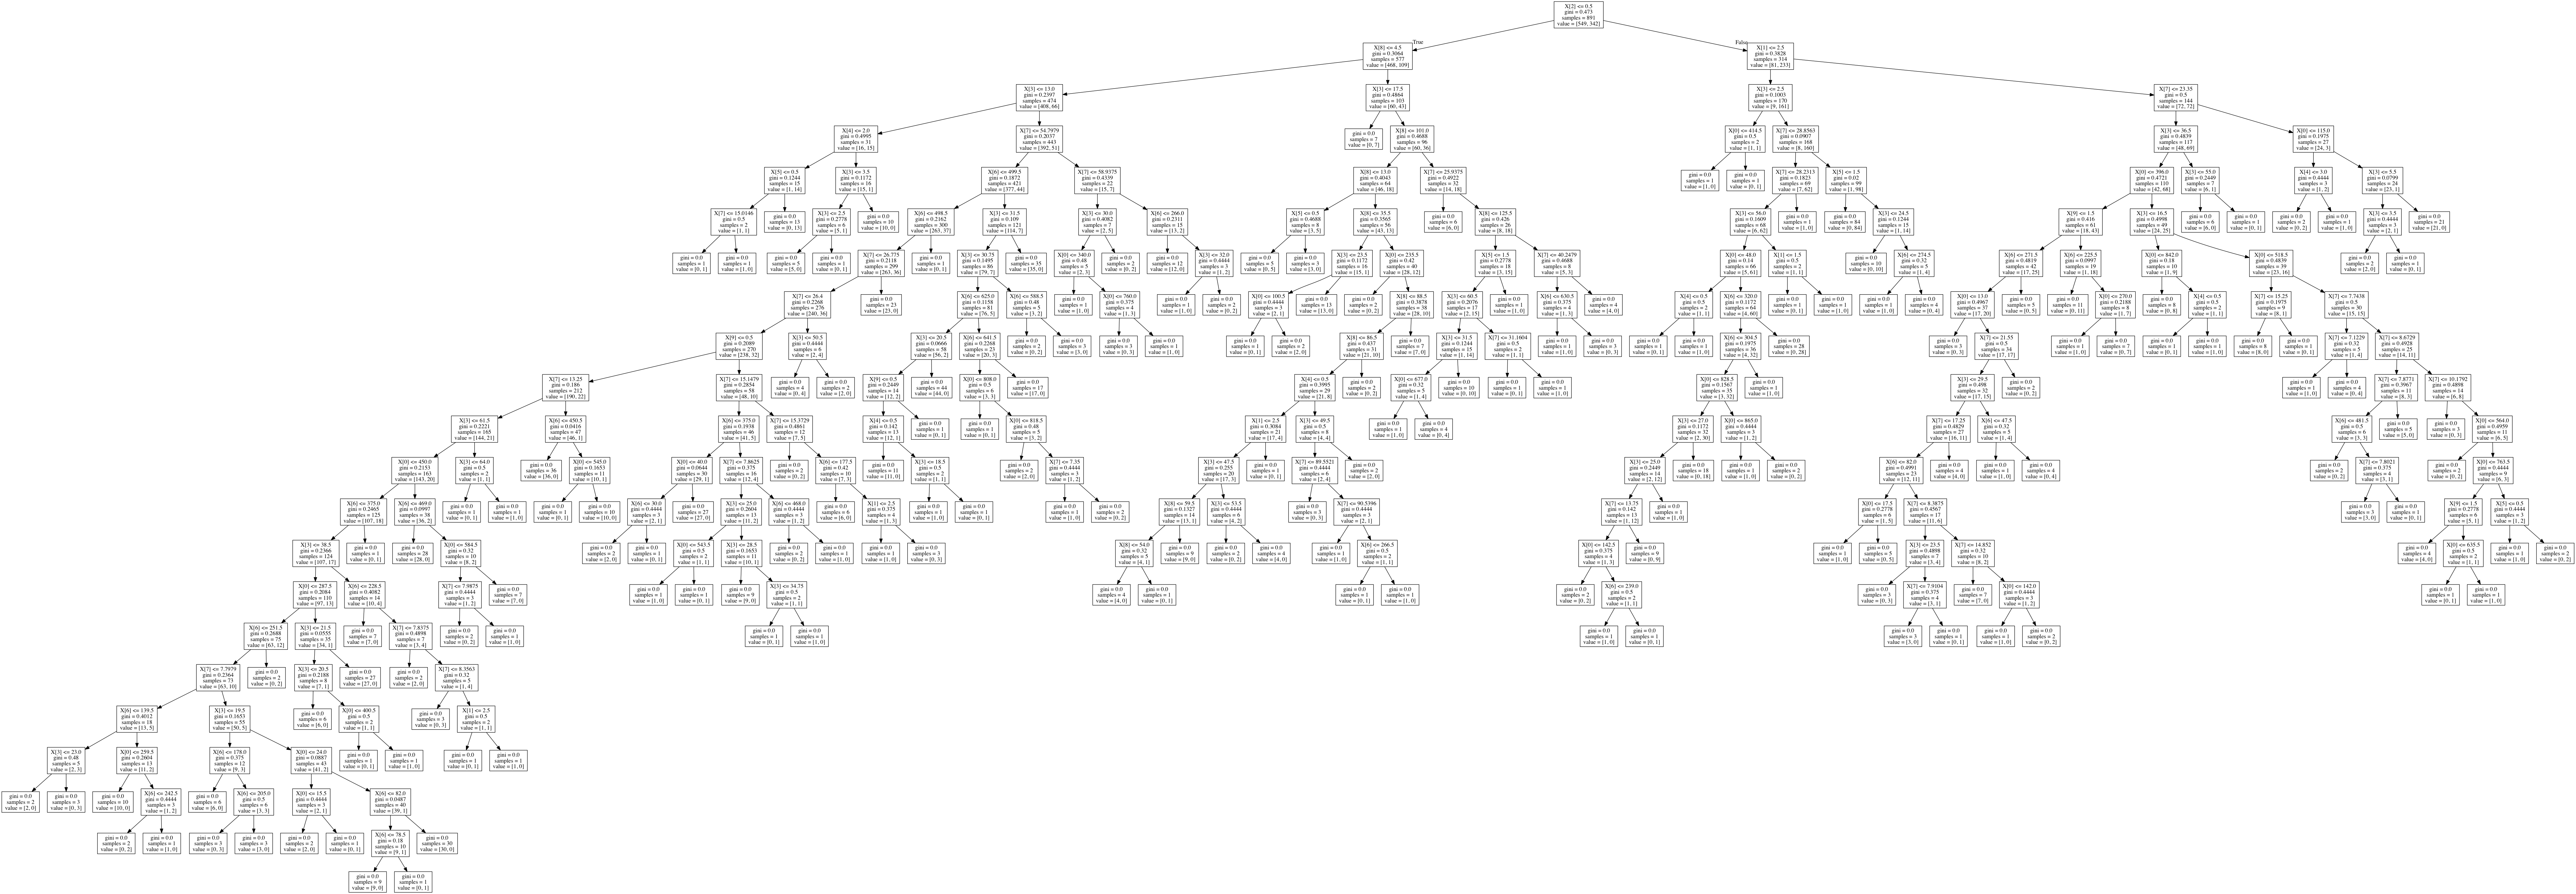

In [17]:
plot_tree(all_features_tree)

In [18]:
auto_features_tree.score(feature_values, target)

1.0

In [15]:
encoded_test_df = encode_object_attributes(impute_null_attributes(test_df.drop(['Name'], 1)))

In [21]:
test_results_csv = extract_features_from_dataframe(encoded_test_df, ['PassengerId'])
test_results_csv['Survived'] = all_features_tree.predict(encoded_test_df.values)
test_results_csv.to_csv('./data/all_features_attempt.csv', index=False)

A submissão atual melhorou a melhor submissão até agora em 0.00957, resultando em uma pontuação final de 0.77512. Deve-se notar, no entanto, a presença de overfitting no conjunto de treinamento.